In [3]:
# first step was to implement this to make sure notebook runs correctly and can reproduce plots
# https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/lectures/Lecture-10-cQED-dispersive-regime.ipynb
%matplotlib widget

import qutip
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
from qutip import (Options, about, basis, coherent, correlation, destroy,
                   expect, mesolve, ptrace, qeye, sigmax, sigmaz,
                   spectrum_correlation_fft, tensor, wigner)
from tqdm import tqdm
from qutip.ui.progressbar import EnhancedTextProgressBar
import h5py
import logging
logging.getLogger().setLevel(logging.INFO) #show logging info 
#TODO add info logging statements for loading and retrieving data, calling mesolve, loading datapoints
#TODO: run same experiemtn twice to verify logging all pts then run again no pts added, then add a few pts, check only added pts calced

#TODO chi (how much frequency changes by), freq ( midpoint), nbar(amplitude)
#normalize points, check amplitudes, check units

In [5]:
class Model: 
    """Class to initiate and hold physical properties of system"""
    
    def __init__(self, **kwargs):
        """Initialize model parameters
        kwargs:
            - N: number of cavity modes, default 10
            - cavityFreq: cavity frequency, default 7.5*np.pi
            - qubitFreq: qubit frequency, default 5.0*np.pi
            - cavityDecay: cavity decay rate, default .1
            - qubitDecay: qubit decay rate, default .0001
            - chi: qubit-cavity coupling strength, default .002*2*np.pi
            - noise: noise strength, default 0 (not implemented)
            - psi0: initial state, default tensor(basis(N, 0), (basis(2, 0)).unit())
        """
        
        # TODO add some uniform variation in parameters (or ability to override)

        ### Define Physical Parameters ###
        self.N_c = 10
        self.N_q = 2

        # TODO make sure consist with GHz vs rad/s
        # XXX possibly off by a factor of 2pi or hbar
        self.cavityFreq = 7.5*np.pi
        self.qubitFreq = 5.0*np.pi

        # NOTE cavity much longer lived than qubit
        self.cavityDecay = .001 # 1-5Mhz
        self.qubitDecay = .0001 #1-5 kHz (or less)

        self.chi = 0.002*2*np.pi #g^2/delta (some conventions are negative)

        # TODO add noise
        self.noise = 0

        # define initial state
        # XXX using 2-level system for qubit
        # later will become transmon
        self.psi0 = tensor(basis(self.N_c, 0), (basis(self.N_q, 0)).unit())

        # ### Construct Operators ###
        # cavity operators
        self.c = tensor(destroy(self.N_c), qeye(self.N_q))
        self.c_H0 = self.c.dag() + self.c
        c_collapse = np.sqrt(self.cavityDecay) * self.c
        # TODO add cavity excitation function of avg. photon number (?)
        c_n = self.c.dag() * self.c

        # qubit operators
        self.q = tensor(qeye(self.N_c), destroy(self.N_q))
        self.q_H0 = self.q.dag() + self.q
        q_collapse = np.sqrt(self.qubitDecay) * self.q
        q_n = self.q.dag() * self.q
        
        # IQ -> phase
        inphase = self.c + self.c.dag()
        quadrature = 1j* (self.c.dag() - self.c)
        # NOTE, rather than measuring photon number directly, measure cavity response phase
        # cavity input drive reflects with phase shift dependent on the cavity photon number

        phase = (inphase + 1j * quadrature)

        self.c_ops = [c_collapse, q_collapse]
        self.e_ops = [c_n, q_n, phase]
        
    def __str__(self) -> str:
        #remove '.' 
        return f"{self.cavityFreq}_{self.cavityDecay}_{self.qubitFreq}_{self.cavityDecay}_{self.chi}".replace('.', '-')

In [6]:
class Hamiltonian():
    """Class to hold Hamiltonian of system"""
    
    def __init__(self, model: Model, tlist=None, progress_bar=None):
        """Initializes Hamiltonian object
        args:
            - model: Model object containing physical parameters
            - tlist: list of times to evaluate Hamiltonian at, if None then defaults to 0 to 150 with 50 points
            - progress_bar: whether to show progress bar, default False
        """
        self.model = model
        self.tlist = tlist if tlist else np.linspace(0, 9000,100)
        self.progress_bar = False if progress_bar is None else progress_bar
        
        # Jaynes-Cummings Hamiltonian (?)
        Id = tensor(qeye(self.model.N_c), qeye(self.model.N_q))
        sz = tensor(qeye(self.model.N_c), sigmaz()) #FIXME sigmaz is two level system operator, needs to be N level
        self.H0 = model.cavityFreq * (self.model.c.dag() * self.model.c + Id / 2.0) + (self.model.qubitFreq / 2.0) * sz - (self.model.chi/2) *(self.model.c.dag() * self.model.c) * sz

    # TODO figure out a more pythonic way to programmatically create 
    # time-dependent terms and c_ops functions (unnecessary?)

    def _qubit_drive_hamiltonian(self, t, kwargs):
        """Time-dependent drive hamiltonian"""
        el = 'qubit'
        return kwargs[f'{el}_amplitude'] * np.cos(kwargs[f'{el}_drive_freq'] * t)
    
    def _cavity_drive_hamiltonian(self, t, kwargs):
        """Time-dependent drive hamiltonian"""
        el = 'cavity'
        return kwargs[f'{el}_amplitude'] * np.cos(kwargs[f'{el}_drive_freq'] * t)

    def wrap_mesolve(self, **kwargs):
        """Runs mesolve with given parameters and returns result
        args:
            args: dictionary of arguments to pass to solver
            - cavity_drive_freq: drive frequency of cavity, if None then drives at the cavity frequency
            - qubit_drive_freq: drive frequency of qubit, if None then drives at the qubit frequency
            (if don't specify, will presume drive at resonance)
            - qubit_amplitude: amplitude of drive on qubit, if None then drive is off
            - cavity_amplitude: amplitude of drive on cavity, if None then drive is off
        """
        H = [self.H0, [self.model.c_H0, self._cavity_drive_hamiltonian], [self.model.q_H0, self._qubit_drive_hamiltonian]]
        args = {}
        args['cavity_drive_freq'] = kwargs.get('cavity_drive_freq', self.model.cavityFreq)
        args['qubit_drive_freq'] = kwargs.get('qubit_drive_freq', self.model.qubitFreq)
        args['qubit_amplitude'] = kwargs.get('qubit_amplitude', 0)
        args['cavity_amplitude'] = kwargs.get('cavity_amplitude', 0)

        # check against this ampltiude heuristic, make sure not exceeding max photon number
        assert args['cavity_amplitude']/np.sqrt(self.model.cavityDecay) <= 1 , "Warning: cavity drive amplitude too large!" # <= self.model.N/4

        # XXX don't know best value for nsteps
        progress_bar = EnhancedTextProgressBar() if self.progress_bar else None
        return mesolve(H, self.model.psi0, self.tlist, self.model.c_ops, self.model.e_ops, args=args,options=Options(nsteps=1000000) , progress_bar=progress_bar)

    def _plot_example(self):
        results = self.wrap_mesolve(qubit_amplitude=0.1, cavity_amplitude=0.01)
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes.plot(self.tlist, results.expect[0], label="Cavity", marker='o')
        axes.plot(self.tlist, results.expect[1], label="Qubit", marker='x')
        axes.legend()
        axes.set_xlabel('Time')
        axes.set_ylabel('Photon number')
        axes.set_title('Rabi oscillations');

        # fig.show()

In [ ]:
# verify that it works, useful for guess and checking appropriate amplitudes
h = Hamiltonian(Model(), progress_bar=True)
h._plot_example()

#note 9000 is where signal stabilized

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

KeyboardInterrupt: 

In [7]:
class DispersiveReadout():
    # FIXME comments
    """Experiment to measure change of the cavity's frequency due to qubit excitation
    Want to measure 
        - the change in the cavity's frequency due to qubit excitation (chi)
        - the cavity's line width (gamma)
        - amplitude of cavity readout (sqrt(n))
    Assumes we know the qubit's frequency and it has a negligible decay rate
    """
    def __init__(self):
        self.model = Model(qubitDecay=0)
        self.H = Hamiltonian(self.model)
        self.num_points = 30
        self.sweep_scale = .005
        self.cavity_drive_freq_list = None
        self.e_op_results =  None
        self.e_op_choice = 2 #1 is q_n, 2 is phase
        self.data_list = []

    def __str__(self) -> str:
        return "cavity_drive_freqS"
    
    def _run(self, cavity_drive_freq_list=None, qubit_amplitude=None, cavity_amplitude=None):
        """Runs experiment and returns results
        args:
            - cavity_drive_freq_list: list of cavity drive frequencies to sweep over
            (if None defaults to (1-sweep_scale)*cavityFreq to (1+sweep_scale)*cavityFreq with self.num_points)
            - qubit_amplitude: amplitude of drive on qubit, if None defaults to .1 #FIXME
            - cavity_amplitude: amplitude of drive on cavity, if None defaults to .1 #FIXME
            
        """
        # Sweep over cavity drive frequencies a) with qubit drive off and b) with qubit drive on
        cavity_drive_freq_list = cavity_drive_freq_list if cavity_drive_freq_list \
            else np.linspace((1.0-self.sweep_scale) * self.model.cavityFreq, (1.0 + self.sweep_scale) * self.model.cavityFreq, self.num_points)
        
        qubit_amplitude = qubit_amplitude if qubit_amplitude else .1 #FIXME
        cavity_amplitude = cavity_amplitude if cavity_amplitude else .01 # FIXME

        
        data_list = self._loadData()
        e_op_results = np.zeros((len(cavity_drive_freq_list), 2))
        for i, cavity_drive_freq in tqdm(enumerate(cavity_drive_freq_list)):
            #FIXME do better code :)
            _flag = 0
            if data_list is None:
                data_list = []
            else:
                
                for data in data_list:
                    if data[0] == cavity_drive_freq and not _flag:
                        logging.info("data found previously")
                        e_op_results[i,0] = data[1]
                        e_op_results[i,1] = data[2]
                        _flag = 1
                    if _flag:
                        break
            
            #data loaded from memory
            if _flag:
                continue

            logging.info("data not found prev, running mesolve")

            # Run mesolve with qubit drive off
            mesolve_result = self.H.wrap_mesolve(cavity_drive_freq=cavity_drive_freq, qubit_amplitude=0, cavity_amplitude=cavity_amplitude)
            # e_op_results[i, 0] = mesolve_result.expect[0][-1] # cavity photon number
            e_op_results[i, 0] = mesolve_result.expect[self.e_op_choice][-1] # cavity phase response

            # Run mesolve with qubit drive on
            mesolve_result = self.H.wrap_mesolve(cavity_drive_freq=cavity_drive_freq, qubit_amplitude=qubit_amplitude, cavity_amplitude=cavity_amplitude)
            # e_op_results[i, 1] = mesolve_result.expect[0][-1] # cavity photon number
            e_op_results[i, 1] = mesolve_result.expect[self.e_op_choice][-1] # cavity phase response

            data_list = np.append(data_list, (cavity_drive_freq, e_op_results[i, 0], e_op_results[i, 1]) )
            self._saveData(data_list) #save data after every iter
        
        self._saveData(data_list)

        return cavity_drive_freq_list, e_op_results
    
    def _loadData(self):
        """load data as dict wit key as freq"""
        logging.info("loading data")
        with h5py.File('data.hdf5', 'r+') as f:
            group = f.require_group(str(self))
            self.data_list = group.require_dataset(str(self.model), shape=(3,3), dtype = 'float32')
            return self.data_list[()]

    def _saveData(self, data_list):
        """save data using h5py"""
        logging.info("saving data")
        #save for cavity drive freq
        with h5py.File('data.hdf5', 'w') as f:
            group = f.require_group(str(self))
            group.create_dataset(name = str(self.model) , data = data_list)
        
               

    def run(self, cavity_drive_freq_list=None, qubit_amplitude=None, cavity_amplitude=None):
        """Runs experiment and plots results"""
        self.cavity_drive_freq_list, self.e_op_results = self._run(cavity_drive_freq_list, qubit_amplitude, cavity_amplitude)
        

    def getChi(self):
        """returns chi"""
        if self.cavity_drive_freq_list is None or  self.e_op_results is None:
            raise("Need to call run() first")
        
        return self.e_op_results[np.argmax(self.e_op_results[:, 1], 1)][0] - self.e_op_results[np.argmax(self.e_op_results[:, 0], 1)][0]
    
    def plot(self):
        """plots the data generated from run (cavity drive freq & cavity phase shift)"""
        #TODO show chi in graph
        if self.cavity_drive_freq_list is None or  self.e_op_results is None:
            raise("Need to call run() first")
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes.plot(self.cavity_drive_freq_list, self.e_op_results[:, 0], label='qubit off', marker='o')
        axes.plot(self.cavity_drive_freq_list, self.e_op_results[:, 1], label='qubit on', marker='x')
        axes.legend()
        axes.set_xlabel('cavity drive frequency')
        axes.set_ylabel('cavity phase shift')
        plt.vlines(self.model.cavityFreq, 0, 2) #plot true freq value of cavity
    


INFO:root:loading data
0it [00:00, ?it/s]INFO:root:data found previously
INFO:root:data not found prev, running mesolve
C:\Users\Okay\AppData\Local\Temp\ipykernel_39400\421127214.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
  e_op_results[i, 0] = mesolve_result.expect[2][-1] # cavity phase response
C:\Users\Okay\AppData\Local\Temp\ipykernel_39400\421127214.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  e_op_results[i, 1] = mesolve_result.expect[2][-1] # cavity phase response
INFO:root:saving data
2it [29:06, 873.16s/it]INFO:root:data not found prev, running mesolve
INFO:root:saving data
3it [48:44, 1000.20s/it]INFO:root:data not found prev, running mesolve
INFO:root:saving data
4it [1:05:45, 1008.06s/it]INFO:root:data not found prev, running mesolve
INFO:root:saving data
5it [1:25:54, 1078.01s/it]INFO:root:data not found prev, running mesolve
INFO:root:saving data
6it [1:46:34, 1131.73s/it]INFO:root:data not foun

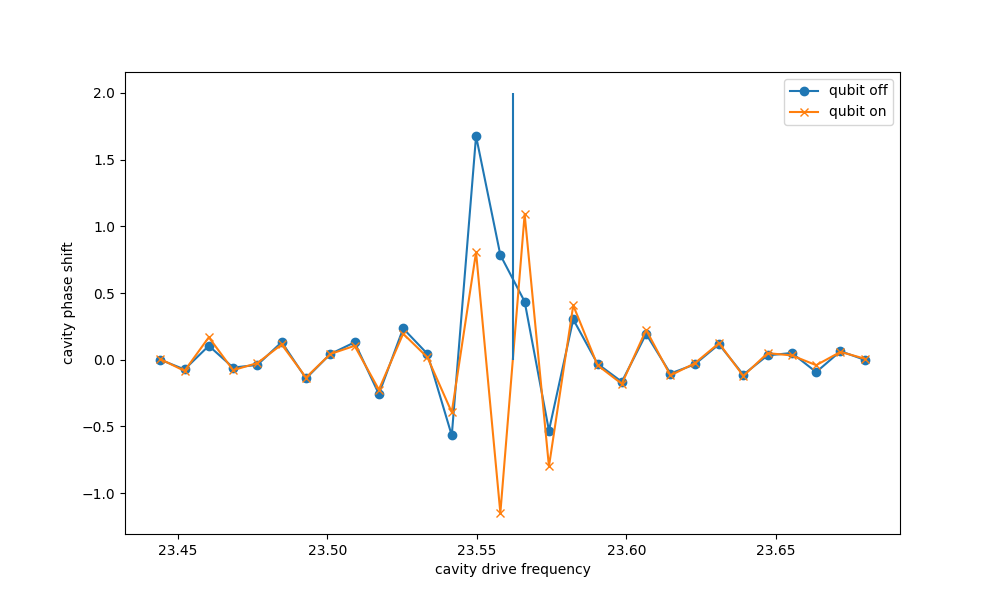

In [30]:
# verify that it works
dr = DispersiveReadout()
dr.run()
dr.plot()
#print(dr.getChi())
#get peak difference in freq for chi



In [57]:
class QubitSpectroscopy():
    """
    Experiment to measure qubit frequency by sweeping over qubit drive frequency and measuring cavity photon number
    """
    def __init__(self):
        self.model = Model()
        self.H = Hamiltonian(self.model)
        self.num_points = 10
        self.sweep_scale = .038
        self.qubit_drive_freq_list = None
        self.e_op_results = None
        self.e_op_choice = 1 # 1 is q_n, 2 is phase
        
    def __str__(self) -> str:
        return "qubit_spectroscopy"
        
    def _run(self, qubit_drive_freq_list=None, qubit_amplitude=None, cavity_amplitude=None):
        """Runs experiment and returns results
        args:
            - qubit_drive_freq_list: list of qubit drive frequencies to sweep over
            (if None defaults to (1-sweep_scale)*qubitFreq to (1+sweep_scale)*qubitFreq with self.num_points)
            - qubit_amplitude: amplitude of drive on qubit, if None defaults to .1 # FIXME
            - cavity_amplitude: amplitude of drive on cavity, if None defaults to .1 # FIXME
        """

        # Sweep over qubit drive frequencies with cavity drive always on resonance
        qubit_drive_freq_list = qubit_drive_freq_list if qubit_drive_freq_list \
            else np.linspace((1.0-self.sweep_scale) * self.model.qubitFreq, (1.0 + self.sweep_scale) * self.model.qubitFreq, self.num_points)
        logging.info(f'qubit freq list: {qubit_drive_freq_list}')
        qubit_amplitude = qubit_amplitude if qubit_amplitude else 0.1 # FIXME
        cavity_amplitude = cavity_amplitude if cavity_amplitude else 0.01 # FIXME
        
        data_list = self._loadData()
        e_op_results = np.zeros((len(qubit_drive_freq_list), 1))
        for i, qubit_drive_freq in tqdm(enumerate(qubit_drive_freq_list)):
            #FIXME do better code :)
            _flag = 0
            if data_list is None:
                data_list = []
            else:
                #TODO implement netter check
                for data in data_list:
                    if data[0] == qubit_drive_freq and not _flag:
                        logging.info("data found previously")
                        e_op_results[i,0] = data[1]
                        _flag = 1
                    if _flag:
                        break
            logging.info(f'check break flag {_flag} for iter {i}')
            #data loaded from memory
            if _flag:
                continue
            
            logging.info("data not found prev, running mesolve")
            mesolve_result = self.H.wrap_mesolve(qubit_drive_freq=qubit_drive_freq, qubit_amplitude=qubit_amplitude, cavity_amplitude=cavity_amplitude)

            # TODO measure through readout signal rather than via expectation values !!!
            # e_op_results[i, 0] = mesolve_result.expect[0][-1] # cavity photon number
            e_op_results[i, 0] = mesolve_result.expect[self.e_op_choice][-1] # cavity phase response
            newData = [(qubit_drive_freq, e_op_results[i, 0])]
            data_list = np.append(data_list, newData, 0)
            self._saveData(data_list) #save data after every iter
        self._saveData(data_list) 
        return qubit_drive_freq_list, e_op_results

    def run(self, qubit_drive_freq_list=None, qubit_amplitude=None, cavity_amplitude=None):
        """Runs experiment"""
        self.qubit_drive_freq_list, self.e_op_results = self._run(qubit_drive_freq_list, qubit_amplitude, cavity_amplitude)

    def _loadData(self):
        """load data as dict wit key as freq"""
        logging.info("loading data")
        with h5py.File('data.hdf5', 'r+') as f:
            group = f.require_group(str(self))
            #data_list_get = group.get(str(self.model))
            data_list = group.require_dataset(str(self.model), shape=(22,2), dtype = 'float32')
            logging.info(f'data_list: {data_list[:]}')
            return data_list[()]

    def _saveData(self, data_list):
        """save data using h5py"""
        logging.info("saving data")
        #save for cavity drive freq
        with h5py.File('data.hdf5', 'w') as f:
            group = f.require_group(str(self))
            group.create_dataset(name = (str(self.model)) , data = data_list)
        
    def plot(self):
        """plots output  from run function"""
        if self.qubit_drive_freq_list is None or self.e_op_results is None:
            raise("Need to call run() first")
        
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes.plot(self.qubit_drive_freq_list, self.e_op_results[:, 0], marker='o')
        axes.set_xlabel('qubit drive frequency')
        axes.set_ylabel('cavity phase shift')
        plt.vlines(self.model.qubitFreq, 0, 10) #add true value of qubit freq

    def get_N_freq(self):
        """returns N and qubit freq"""
        if self.qubit_drive_freq_list is None or self.e_op_results is None:
            raise("Need to call run() first")
        
        #get nbar
        maxnbar = np.max(self.e_op_results[:, 0]) #get nbar
        freq = self.qubit_drive_freq_list[np.where(maxnbar)]
        return maxnbar, freq

    def _lorentzian(self, x,amplitude, center, width):
        """callable function for curve fitting function"""
        return amplitude*width**2/((x-center)**2+width**2)

    def fit_lorentzian(self):
        """fit data from mesolve to lorentzian"""
        #note: pcov_lorentz used if want to find error
        popt_lorentz, pcov_lorentz = scipy.optimize.curve_fit(_lorentzian, self.qubit_drive_freq_list, self.e_op_results[:, 0]) #FIXME find vars that fit p0 for initial guesses
        print(f'amplitude : {popt_lorentz[0]}, center: {popt_lorentz[1]}, width{popt_lorentz[2]}')

In [56]:
qs = QubitSpectroscopy()
qs.run()
qs.plot()
nbar , freq = qs.get_N_freq()
print('nbar = ', nbar)
print('freq', freq)
#use this plot nbar, qubit freq


INFO:root:qubit freq list: [15.11106066 15.24370569 15.37635071 15.50899573 15.64164076 15.77428578
 15.9069308  16.03957583 16.17222085 16.30486587]
INFO:root:loading data
INFO:root:data_list: [[15.11106066  1.58385984]
 [15.11106066  1.58385984]
 [15.17389252  1.59051293]
 [15.17389252  1.59051293]
 [15.23672437  1.60060999]
 [15.29955622  1.61607045]
 [15.36238808  1.63765393]
 [15.42521993  1.65455619]
 [15.48805178  1.66277706]
 [15.55088364  1.75062851]
 [15.61371549  1.42614382]
 [15.67654734 -0.19717261]
 [15.73937919  1.38407154]
 [15.80221105  1.681776  ]
 [15.8650429   1.6625962 ]
 [15.92787475  1.65213215]
 [15.99070661  1.64220096]
 [16.05353846  1.62100107]
 [16.11637031  1.60438366]
 [16.17920217  1.59326197]
 [16.24203402  1.5859121 ]
 [16.30486587  1.58091703]]
0it [00:00, ?it/s]INFO:root:data found previously
INFO:root:check break flag 1 for iter 0
INFO:root:check break flag 0 for iter 1
INFO:root:data not found prev, running mesolve
1it [07:46, 466.79s/it]


KeyboardInterrupt: 